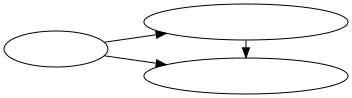

In [1]:
from graphviz import Digraph
import PIL.Image

dot = Digraph(comment='The Round Table',format="png")
dot.graph_attr['rankdir'] = 'LR'

def jnode(g, n1,n2):
    g.node(n1,n2)

jnode(dot,'A', 'アーサー王')
jnode(dot,'B', '賢明なるベディヴィア卿')
jnode(dot,'L', '勇猛なるランスロット卿')

dot.edges(['AB', 'AL'])
dot.edge('B', 'L', constraint='False')
dot

jupyter notebook 上であれば，上のように日本語を含む dot 記述がなんの苦労もなく，問題なく表示できる．

ところが，これをレンダリングしてみると，

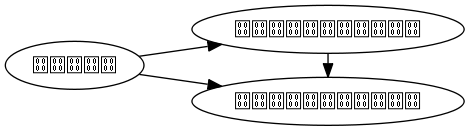

In [2]:
dot.render('aser')
PIL.Image.open('aser.png')

このように文字化けしてしまう．後でフォント指定した場合との比較のために，このときの dot 記述を確認しておくと．

In [3]:
print(dot.source)

// The Round Table
digraph {
	graph [rankdir=LR]
	A [label="アーサー王"]
	B [label="賢明なるベディヴィア卿"]
	L [label="勇猛なるランスロット卿"]
	A -> B
	A -> L
	B -> L [constraint=False]
}


日本語をレンダリング画像でも正しく表示するためには，次のようにフォントを指定すればよい．

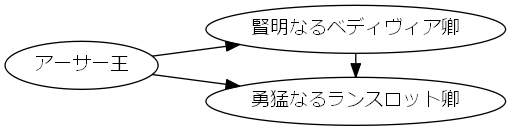

In [4]:
dot1 = Digraph(comment='The Round Table',format="png")
dot1.graph_attr['rankdir'] = 'LR'

def jnode(g, n1,n2):
    g.node(n1,n2, fontname="Meiryo")

jnode(dot1,'A', 'アーサー王')
jnode(dot1,'B', '賢明なるベディヴィア卿')
jnode(dot1,'L', '勇猛なるランスロット卿')

dot1.edges(['AB', 'AL'])
dot1.edge('B', 'L', constraint='False')
dot1.render('aser1')
PIL.Image.open('aser1.png')

dot 記述を確認しておくと，

In [5]:
print(dot1.source)

// The Round Table
digraph {
	graph [rankdir=LR]
	A [label="アーサー王" fontname=Meiryo]
	B [label="賢明なるベディヴィア卿" fontname=Meiryo]
	L [label="勇猛なるランスロット卿" fontname=Meiryo]
	A -> B
	A -> L
	B -> L [constraint=False]
}


Diagraph ではこれで問題解決なのだけど，dot ファイルや pydotplus で生成された dot 構造体の場合，例えば，

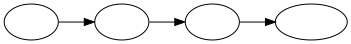

In [6]:
from graphviz import Source
src = Source('digraph "the holy hand grenade" { rankdir=LR; A[label="太郎"] B[label="次郎"] C[label="三郎"] D[label="ゴール"] A -> B -> C -> D }')
src.format='png'
src

これの場合，

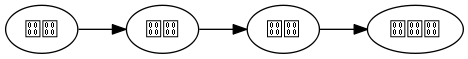

In [7]:
src.render('test')
PIL.Image.open('test.png')

やはり化けてしまうのだが，src の場合，個々のノードにフォント指定をする手段がないので，困ってしまった．
（上のケースなら，font指定した dot 記述を手で書けばよいわけだが，決定木生成プログラムなどで作られた dot 記述の場合どうしようかと悩んだわけである）

In [8]:
srctext = src.source
srctext

'digraph "the holy hand grenade" { rankdir=LR; A[label="太郎"] B[label="次郎"] C[label="三郎"] D[label="ゴール"] A -> B -> C -> D }'

pydotplus.graphviz.graph_from_dot_data というメソッドで，dot のべた記述から グラフ構造体が作れる

In [9]:
import pydotplus
g = pydotplus.graphviz.graph_from_dot_data(srctext)

こいつは render メソッドや source をメンバーとして持っていないからややこしい．  
ソースを取り出したいときは，to_string()メソッド，レンダリングしたければ，write_png()を使う．

In [10]:
g.to_string()

'digraph "the holy hand grenade" {\nrankdir=LR;\nA [label="太郎"];\nB [label="次郎"];\nC [label="三郎"];\nD [label="ゴール"];\nA -> B;\nB -> C;\nC -> D;\n}\n'

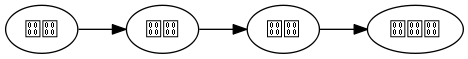

In [11]:
g.write_png("test1.png")
PIL.Image.open("test.png")

このメソッドはやはり文字化けしてしまう．

これを解決するには，ノードをひとつずつ，**fontname="Meiro"**を付け加える．
どうしたらよいかと悩んだが，こうすれば解決することがわかった．

In [12]:
for node in g.get_nodes():
    node.set_fontname("Meiryo")
for edge in g.get_edges():
    edge.set_fontname("Meiryo")
for nl in g.get_node_list():
    nl.set_fontname("Meiryo")

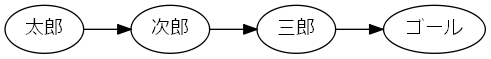

In [13]:
g.write_png("test2.png")
PIL.Image.open("test2.png")

In [14]:
g.to_string()

'digraph "the holy hand grenade" {\nrankdir=LR;\nA [fontname=Meiryo, label="太郎"];\nB [fontname=Meiryo, label="次郎"];\nC [fontname=Meiryo, label="三郎"];\nD [fontname=Meiryo, label="ゴール"];\nA -> B  [fontname=Meiryo];\nB -> C  [fontname=Meiryo];\nC -> D  [fontname=Meiryo];\n}\n'

問題は次のケース．今のところ解決法が見いだせない．

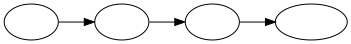

In [15]:
from graphviz import Source
g2 = Source('digraph "the holy hand grenade" { rankdir=LR; 太郎 -> 次郎 -> 三郎 -> ゴール }')
g2.format='png'
g2


In [16]:
srctext2 = g2.source
g3 = pydotplus.graphviz.graph_from_dot_data(srctext2)

In [17]:
for node in g3.get_nodes():
    node.set_fontname("Meiryo")
for edge in g3.get_edges():
    edge.set_fontname("Meiryo")
for nl in g3.get_node_list():
    nl.set_fontname("Meiryo")

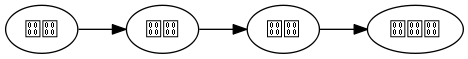

In [18]:
g3.write_png("test3.png")
PIL.Image.open("test3.png")

In [19]:
g3.to_string()

'digraph "the holy hand grenade" {\nrankdir=LR;\n"太郎" -> "次郎"  [fontname=Meiryo];\n"次郎" -> "三郎"  [fontname=Meiryo];\n"三郎" -> "ゴール"  [fontname=Meiryo];\n}\n'

In [20]:
xx = 'digraph "the holy hand grenade" {fontname=Meiryo  \nrankdir=LR;\n"太郎" -> "次郎"  [fontname=Meiryo];\n"次郎" -> "三郎"  [fontname=Meiryo];\n"三郎" -> "ゴール"  [fontname=Meiryo];\n}\n'

In [21]:
g4 = pydotplus.graphviz.graph_from_dot_data(xx)

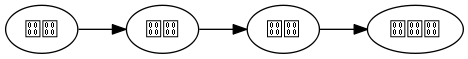

In [22]:
g4.write_png("test3.png")
PIL.Image.open("test3.png")

In [23]:
for node in g3.get_edges():
    node.get_destination()
    node.
        

SyntaxError: invalid syntax (<ipython-input-23-c3f7b12eae5c>, line 3)